# Relative Value Credit Analysis

This notebook explores the features of the relative value credit analysis framework. We will walk through the full pipeline, from data loading to backtesting, for two pairs of credit default swap (CDS) indices.

## 1. Load and Prepare Data

First, we load the data for our two pairs of tickers. We use the `data_agent` to handle loading the CSV files, cleaning them by forward-filling missing values, and synchronizing the time series to a common date index. We'll use the following pairs:

- **Pair 1:** `CDXTEL15` and `CDXTHL15`
- **Pair 2:** `ITRXTE5I` and `ITRXTSF5`

In [1]:
import sys
import os
# Add src to the python path
sys.path.append(os.path.abspath('src'))

import data_agent as da

# --- Pair 1 ---
ticker_x1 = 'CDXTEL15'
ticker_y1 = 'CDXTHL15'

# Load data
data_x1 = da.load_data(ticker_x1)
data_y1 = da.load_data(ticker_y1)

# Clean data
data_x1_clean = da.clean_data(data_x1)
data_y1_clean = da.clean_data(data_y1)

# --- Fix in Cell VSC-711c450e ---
# The function returns tuple, ensure this is handled correctly
result1 = da.synchronize_data(data_x1_clean, data_y1_clean)
sync_x1, sync_y1 = result1  # result1 is already a tuple

# Fix column references based on actual data structure
# Check the loaded data structure first
print("Data x1 columns:", data_x1.columns.tolist())
print("Data y1 columns:", data_y1.columns.tolist())
print("Sync x1 columns:", sync_x1.columns.tolist())
print("Sync y1 columns:", sync_y1.columns.tolist())

# --- Pair 2 ---
ticker_x2 = 'ITRXTE5I'
ticker_y2 = 'ITRXTSF5'

# Load data
data_x2 = da.load_data(ticker_x2)
data_y2 = da.load_data(ticker_y2)

# Clean data
data_x2_clean = da.clean_data(data_x2)
data_y2_clean = da.clean_data(data_y2)

result2 = da.synchronize_data(data_x2_clean, data_y2_clean)
sync_x2, sync_y2 = result2  # result2 is already a tuple

print("Data loaded and prepared for both pairs.")
print("Pair 1 shapes:", sync_x1.shape, sync_y1.shape)
print("Pair 2 shapes:", sync_x2.shape, sync_y2.shape)

Data x1 columns: ['PX_LAST']
Data y1 columns: ['PX_LAST']
Sync x1 columns: ['PX_LAST']
Sync y1 columns: ['PX_LAST']
Data loaded and prepared for both pairs.
Pair 1 shapes: (4640, 1) (4640, 1)
Pair 2 shapes: (4695, 1) (4695, 1)


## 2. Run Modeling Pipeline

Next, we run the modeling pipeline on our prepared data. This involves two main steps:

1.  **Linear Regression:** We calculate the `beta` (hedge ratio) and `residuals` between the two series over a long-term lookback window.
2.  **Ornstein-Uhlenbeck (OU) Process:** We fit an OU process to the residuals to model their mean-reverting behavior. This gives us the parameters `theta` (speed of reversion), `mu` (long-term mean), and `sigma` (volatility).

We use different lookback parameters for each pair to demonstrate flexibility.

In [2]:
import modeling_agent as ma

# --- Data Validation ---
print("=== Data Validation ===")
print(f"Sync X1 date range: {sync_x1.index.min()} to {sync_x1.index.max()}")
print(f"Sync Y1 date range: {sync_y1.index.min()} to {sync_y1.index.max()}")
print(f"Sync X2 date range: {sync_x2.index.min()} to {sync_x2.index.max()}")
print(f"Sync Y2 date range: {sync_y2.index.min()} to {sync_y2.index.max()}")

# Check for overlapping date ranges
common_dates_1 = sync_x1.index.intersection(sync_y1.index)
common_dates_2 = sync_x2.index.intersection(sync_y2.index)
print(f"Pair 1 common dates: {len(common_dates_1)} observations")
print(f"Pair 2 common dates: {len(common_dates_2)} observations")

# Data is already synchronized and aligned from previous step
# Extract the price series for modeling
sync_x1_series = sync_x1['PX_LAST']
sync_y1_series = sync_y1['PX_LAST']
sync_x2_series = sync_x2['PX_LAST']
sync_y2_series = sync_y2['PX_LAST']

# --- Pair 1 Modeling ---
regression_lookback1 = '2Y'
ou_lookback1 = '26W'

print("\n=== Running Pair 1 Modeling ===")
beta1, residuals1, theta1, mu1, sigma1 = ma.run_modeling_pipeline(
    sync_x1_series,
    sync_y1_series,
    regression_lookback1,
    ou_lookback1
)

=== Data Validation ===
Sync X1 date range: 2007-03-27 00:00:00 to 2025-10-23 00:00:00
Sync Y1 date range: 2007-03-27 00:00:00 to 2025-10-23 00:00:00
Sync X2 date range: 2007-03-20 00:00:00 to 2025-10-23 00:00:00
Sync Y2 date range: 2007-03-20 00:00:00 to 2025-10-23 00:00:00
Pair 1 common dates: 4640 observations
Pair 2 common dates: 4695 observations

=== Running Pair 1 Modeling ===


In [3]:
# --- Pair 2 Modeling ---
regression_lookback2 = '5Y'
ou_lookback2 = '52W'

print("\n=== Running Pair 2 Modeling ===")
beta2, residuals2, theta2, mu2, sigma2 = ma.run_modeling_pipeline(
    sync_x2_series,
    sync_y2_series,
    regression_lookback2,
    ou_lookback2
)

print("--- Pair 1 Results ---")
print(f"Beta: {beta1:.4f}")
print(f"Theta: {theta1:.4f}")
print(f"Mu: {mu1:.4f}")
print(f"Sigma: {sigma1:.4f}")
print(f"Is Mean Reverting: {ma.is_mean_reverting(theta1)}")

print("\n--- Pair 2 Results ---")
print(f"Beta: {beta2:.4f}")
print(f"Theta: {theta2:.4f}")
print(f"Mu: {mu2:.4f}")
print(f"Sigma: {sigma2:.4f}")
print(f"Is Mean Reverting: {ma.is_mean_reverting(theta2)}")


=== Running Pair 2 Modeling ===
--- Pair 1 Results ---
Beta: 2.3953
Theta: 35.4651
Mu: -1.1990
Sigma: 5.8134
Is Mean Reverting: True

--- Pair 2 Results ---
Beta: 1.1043
Theta: 5.9000
Mu: 0.1029
Sigma: 0.3581
Is Mean Reverting: True


## 3. Generate Signals

Now we generate trading signals from the modeling results. The signal is essentially a z-score of the current residual, normalized by the equilibrium volatility of the OU process. This tells us how far the current relationship has deviated from its long-term mean.

In [4]:
import signal_agent as sa
import pandas as pd

# Add in Cell VSC-8ce66374 after modeling
# Initialize defaults so later prints are safe even if signal generation is skipped
eq_vol1 = None
eq_vol2 = None
signals1 = None
signals2 = None

if not ma.is_mean_reverting(theta1):
    print("Warning: Pair 1 is not mean-reverting. Skipping signal generation.")
else:
    # Generate signals for Pair 1
    eq_vol1 = sa.calculate_equilibrium_volatility(theta1, sigma1)
    signals1 = residuals1.apply(lambda r: sa.generate_signal(r, mu1, eq_vol1))

if not ma.is_mean_reverting(theta2):
    print("Warning: Pair 2 is not mean-reverting. Skipping signal generation.")
else:
    # Generate signals for Pair 2
    eq_vol2 = sa.calculate_equilibrium_volatility(theta2, sigma2)
    signals2 = residuals2.apply(lambda r: sa.generate_signal(r, mu2, eq_vol2))
    
print("--- Pair 1 Signal ---")
if eq_vol1 is not None:
    print(f"Equilibrium Volatility: {eq_vol1:.4f}")
else:
    print("Equilibrium Volatility: N/A")

print("Last 5 signals:")
if signals1 is not None:
    print(signals1.tail())
else:
    print("Signals not generated for Pair 1.")

print("\n--- Pair 2 Signal ---")
if eq_vol2 is not None:
    print(f"Equilibrium Volatility: {eq_vol2:.4f}")
else:
    print("Equilibrium Volatility: N/A")

print("Last 5 signals:")
if signals2 is not None:
    print(signals2.tail())
else:
    print("Signals not generated for Pair 2.")

--- Pair 1 Signal ---
Equilibrium Volatility: 0.6903
Last 5 signals:
DATE
2025-10-17   -0.273083
2025-10-20   -0.765942
2025-10-21    0.067849
2025-10-22    0.123215
2025-10-23   -0.212337
dtype: float64

--- Pair 2 Signal ---
Equilibrium Volatility: 0.1042
Last 5 signals:
DATE
2025-10-17    0.088093
2025-10-20    0.140571
2025-10-21    0.039607
2025-10-22   -0.077572
2025-10-23   -0.027104
dtype: float64


## 4. Run Backtest and Visualize

Finally, we run a simple backtest to evaluate the performance of our signals and visualize the results. The backtest will long the spread when the signal is below a certain threshold (e.g., -1.5) and short it when the signal is above the threshold (e.g., 1.5). We'll also generate plots for:

-   The time series of the residuals.
-   The residuals with the fitted OU mean.
-   The historical trading signals.

In [5]:
import backtest_agent as ba

SIGNAL_THRESHOLD = 1.5

backtest_results1 = ba.run_backtest(sync_y1['PX_LAST'], signals1, SIGNAL_THRESHOLD)
backtest_results2 = ba.run_backtest(sync_y2['PX_LAST'], signals2, SIGNAL_THRESHOLD)

print("--- Pair 1 Backtest Results ---")
for metric, value in backtest_results1.items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

print("\n--- Pair 2 Backtest Results ---")
for metric, value in backtest_results2.items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

--- Pair 1 Backtest Results ---
Cagr: -0.0020
Sharpe Ratio: -0.1189
Max Drawdown: -0.0697

--- Pair 2 Backtest Results ---
Cagr: -0.0067
Sharpe Ratio: -0.9413
Max Drawdown: -0.1244


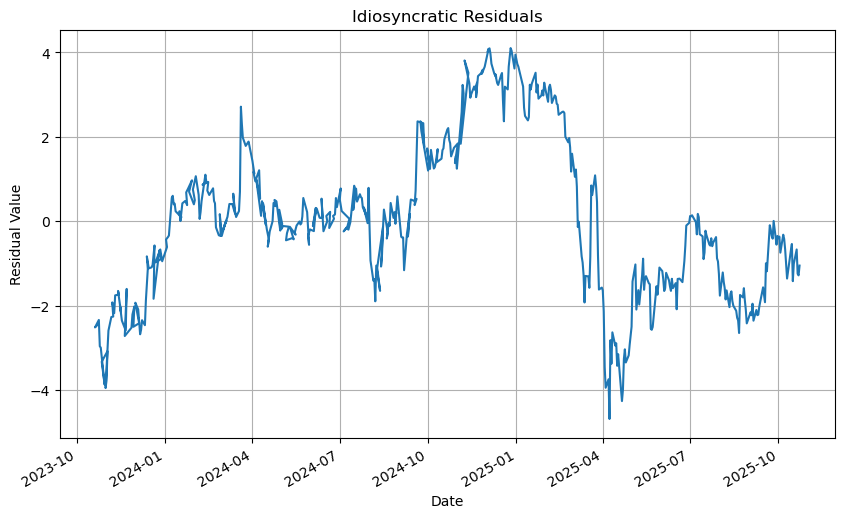

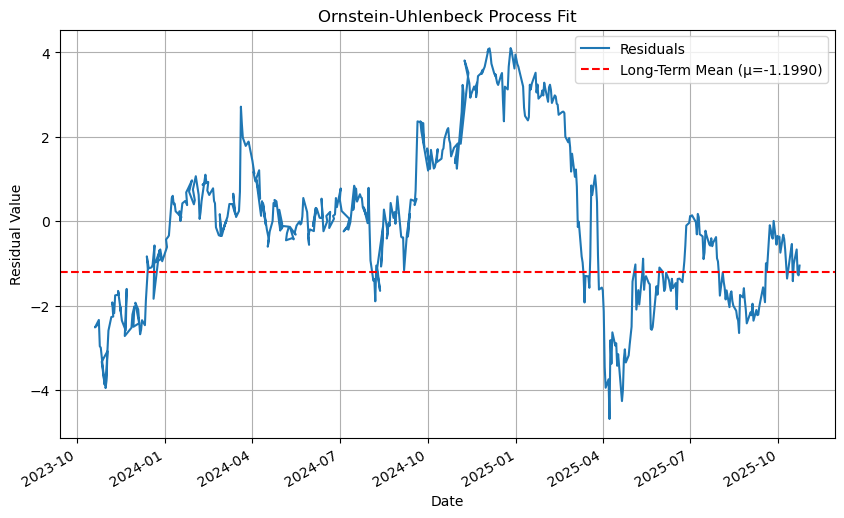

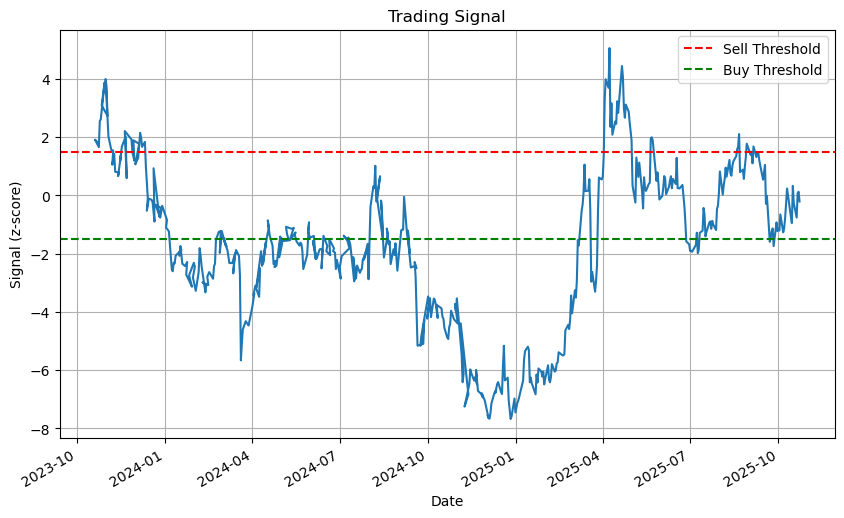

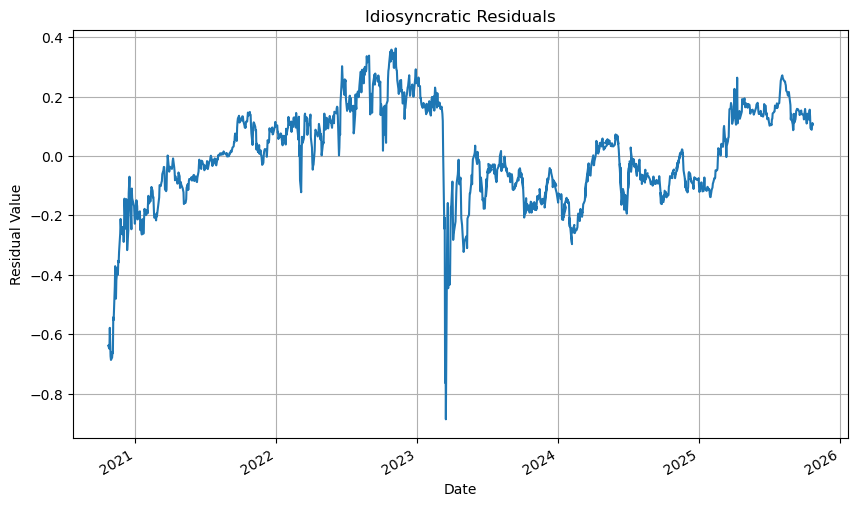

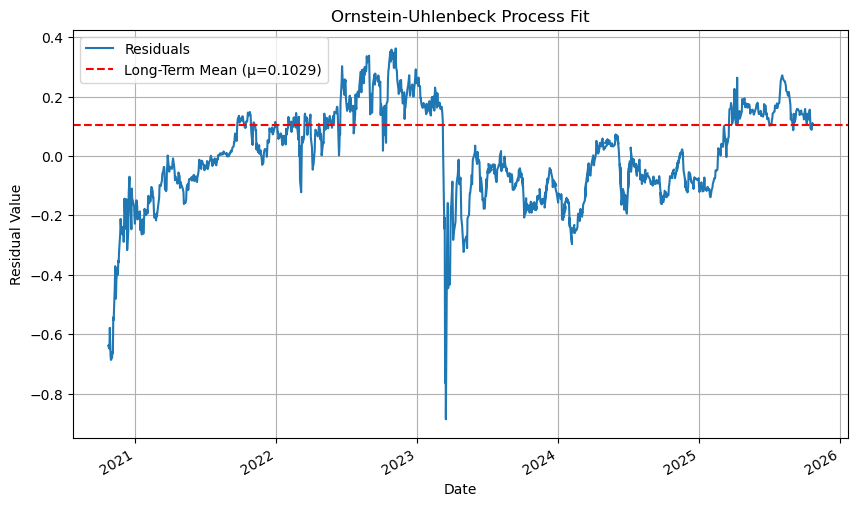

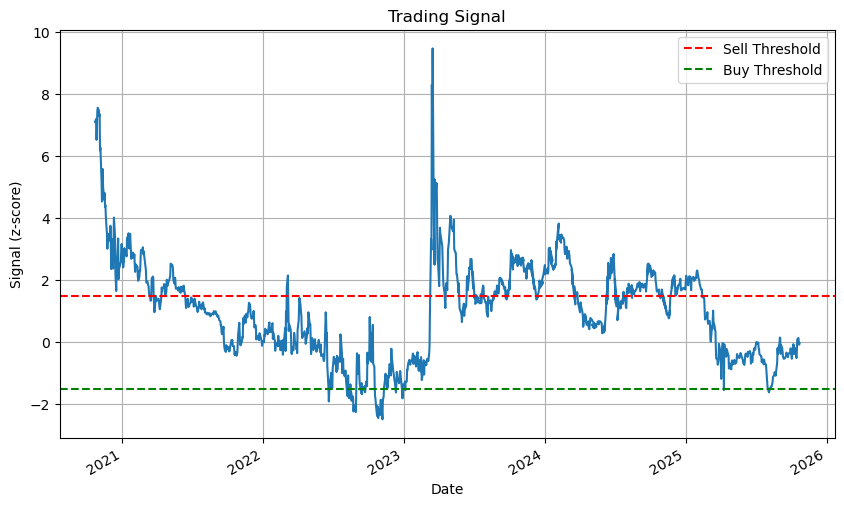


Visualizations displayed.


In [6]:
# --- Visualizations ---

# Display plots instead of saving to files
ba.plot_residuals(residuals1)
ba.plot_ou_fit(residuals1, mu1)
ba.plot_signal(signals1)

ba.plot_residuals(residuals2)
ba.plot_ou_fit(residuals2, mu2)
ba.plot_signal(signals2)

print("\nVisualizations displayed.")